In [ ]:
#主谓关系

In [6]:
import pandas as pd
import spacy
import re
from collections import defaultdict, Counter
from tqdm import tqdm

# ✅ 加载 spaCy 中文模型
nlp = spacy.load("zh_core_web_sm")

# ✅ 自定义关键词
platform_terms = [
    "平台", "公司", "淘宝", "知乎", "新浪", "微博", "豆瓣", "微信", "网易", "抖音",
    "e家帮", "京东", "链家", "哔哩哔哩", "e家帮家政", "yy直播", "人民网", "优酷",
    "凤凰网", "唯品会", "喜马拉雅", "央视网", "快手", "我爱我家", "拼多多", "搜狗",
    "携程", "新浪微博", "晋江文学城", "滴滴", "滴答出行", "爱奇艺", "百度", "神州专车",
    "网易严选", "网易游戏", "美团外卖", "腾讯新闻", "腾讯视频", "起点中文网", "高德", "360"
]
user_terms = ["用户", "您", "帐号"]
right_verbs = ["可", "可以", "有权", "享有", "拥有", "得以", "能够"]
duty_verbs = ["应", "应当", "不得", "承担", "负责", "履行", "必须", "保证"]
negation_words = ["不", "未", "没有", "不会", "不能", "并非", "无", "无需"]

# ✅ 读取原始文件
df = pd.read_excel("/Users/jitianran/Desktop/export/协议数据汇总.xlsx")
df.columns = df.columns.str.strip()
df = df.dropna(subset=["协议内容", "时间", "平台名称", "平台性质"])
df["时间"] = pd.to_datetime(df["时间"])

# ✅ 初始化记录容器
results = []

# ✅ 处理每一条协议（加入 tqdm 进度条）
for _, row in tqdm(df.iterrows(), total=len(df), desc="正在提取主谓标签"):
    text = str(row["协议内容"]).replace("\n", "").replace("\r", "")
    time = row["时间"].date()
    platform = row["平台名称"]
    category = row["平台性质"]

    # ✳️ 合并冒号句
    sentences = []
    buffer = ""
    for sent in re.split(r"[。；;!?！\n]", text):
        if not sent.strip():
            continue
        if "：" in sent or ":" in sent:
            buffer = sent
            continue
        if buffer:
            sent = buffer + "：" + sent
            buffer = ""
        sentences.append(sent)

    # ✳️ spaCy 分析
    for sent in sentences:
        doc = nlp(sent)
        for token in doc:
            if token.pos_ == "VERB" and token.dep_ in ("ROOT", "conj", "ccomp"):
                verb = token.text
                subject = None
                has_neg = False

                for child in token.children:
                    if child.dep_ in ("nsubj", "nsubj:pass"):
                        subject = child.text
                    if child.dep_ in ("advmod", "neg") and child.text in negation_words:
                        has_neg = True

                if not subject:
                    continue

                # ✳️ 主体归类
                if any(t in subject for t in platform_terms):
                    subj_type = "平台"
                elif any(t in subject for t in user_terms):
                    subj_type = "用户"
                else:
                    continue

                # ✳️ 动词归类
                clause_type = None
                if any(rv in verb for rv in right_verbs):
                    clause_type = "权利"
                    label = f"{subj_type}_权利"
                elif any(dv in verb for dv in duty_verbs):
                    if subj_type == "平台" and has_neg:
                        clause_type = "免责"
                        label = "平台_免责"
                    else:
                        clause_type = "义务"
                        label = f"{subj_type}_义务"
                else:
                    continue

                # ✅ 保存结果
                results.append({
                    "时间": time,
                    "平台": platform,
                    "平台类别": category,
                    "句子内容": sent.strip(),
                    "主语": subject,
                    "动词": verb,
                    "标签": label
                })

# ✅ 导出 Excel
out_df = pd.DataFrame(results)
out_df.to_excel("协议主谓标签提取结果.xlsx", index=False)

print("✅ 提取完成，结果已保存为：协议主谓标签提取结果.xlsx")

正在提取主谓标签: 100%|███████████████████████| 560/560 [04:46<00:00,  1.96it/s]


✅ 提取完成，结果已保存为：协议主谓标签提取结果.xlsx


In [ ]:
import spacy

nlp = spacy.load("zh_core_web_sm")

In [10]:
import pandas as pd
import spacy
from tqdm import tqdm

# 加载 spaCy 中文模型
nlp = spacy.load("zh_core_web_sm")

# 读取原始 Excel 文件
df = pd.read_excel("/Users/jitianran/Desktop/export/协议数据汇总.xlsx")

# 初始化结果列表
results = []

# tqdm 包装 DataFrame 行迭代器，显示进度条
for idx, row in tqdm(df.iterrows(), total=len(df), desc="正在处理协议文本"):
    time = row["时间"]
    platform = row["平台名称"]
    category = row["平台性质"]
    raw_text = str(row["协议内容"]).strip()

    # 切句
    doc = nlp(raw_text)
    sentences = [sent.text.strip() for sent in doc.sents]

    # 去除不以句号结尾的内容
    valid_sentences = [s for s in sentences if s.endswith("。")]

    # 编号并保存
    for i, sent in enumerate(valid_sentences, start=1):
        results.append({
            "时间": time,
            "平台名称": platform,
            "平台性质": category,
            "句子编号": i,
            "句子内容": sent
        })

# 保存为 Excel 文件
output_df = pd.DataFrame(results)
output_df.to_excel("/Users/jitianran/Desktop/切句结果.xlsx", index=False)

正在处理协议文本: 100%|███████████████████████| 560/560 [04:04<00:00,  2.29it/s]


In [ ]:
#主谓关系标记

In [11]:
import pandas as pd
import spacy
from tqdm import tqdm

# 加载中文模型（确保已正确安装）
nlp = spacy.load("zh_core_web_sm")

# 读取 Excel 文件
df = pd.read_excel("/Users/jitianran/Desktop/切句结果.xlsx")

# 关键词定义
platform_terms = [
    "平台", "公司", "我们", "淘宝", "知乎", "新浪", "微博", "豆瓣", "微信", "网易", "抖音",
    "e家帮", "京东", "链家", "哔哩哔哩", "e家帮家政", "yy直播", "人民网", "优酷",
    "凤凰网", "唯品会", "喜马拉雅", "央视网", "快手", "我爱我家", "拼多多", "搜狗",
    "携程", "新浪微博", "晋江文学城", "滴滴", "滴答出行", "爱奇艺", "百度", "神州专车",
    "网易严选", "网易游戏", "美团外卖", "腾讯新闻", "腾讯视频", "起点中文网", "高德", "360"
]
user_terms = ["用户", "您", "帐号"]
right_verbs = ["可", "可以", "有权", "享有", "拥有", "得以", "能够"]
duty_verbs = ["应", "应当", "不得", "承担", "负责", "履行", "必须", "保证"]
negation_words = ["不", "未", "没有", "不会", "不能", "并非", "无", "无需"]

# 新增列
results = []

# tqdm 进度条
for idx, row in tqdm(df.iterrows(), total=len(df)):
    time = row["时间"]
    platform = row["平台名称"]
    nature = row["平台性质"]
    sentence_id = row["句子编号"]
    sentence = str(row["句子内容"])

    doc = nlp(sentence)
    category = "未知"

    subject_tokens = [token for token in doc if token.dep_ in ("nsubj", "nsubj:pass")]
    verb_tokens = [token for token in doc if token.pos_ == "VERB" or token.dep_ == "ROOT"]

    # 将句子拆解为主语-动词组合基础上打标签
    subject_text = "".join([t.text for t in subject_tokens])
    verb_text = "".join([t.text for t in verb_tokens])

    # 归类逻辑
    if any(term in subject_text for term in platform_terms):
        if any(v in verb_text for v in right_verbs):
            category = "平台_权利"
        elif any(v in verb_text for v in duty_verbs):
            if any(neg in sentence for neg in negation_words):
                category = "平台_免责"
            else:
                category = "平台_义务"
    elif any(term in subject_text for term in user_terms):
        if any(v in verb_text for v in right_verbs):
            category = "用户_权利"
        elif any(v in verb_text for v in duty_verbs):
            category = "用户_义务"

    # 存储结果
    results.append({
        "时间": time,
        "平台名称": platform,
        "平台性质": nature,
        "句子编号": sentence_id,
        "句子内容": sentence,
        "句子类别": category
    })

# 保存为新的 Excel
output_df = pd.DataFrame(results)
output_df.to_excel("/Users/jitianran/Desktop/主谓识别结果.xlsx", index=False)

100%|████████████████████████████████████| 56663/56663 [04:05<00:00, 231.19it/s]


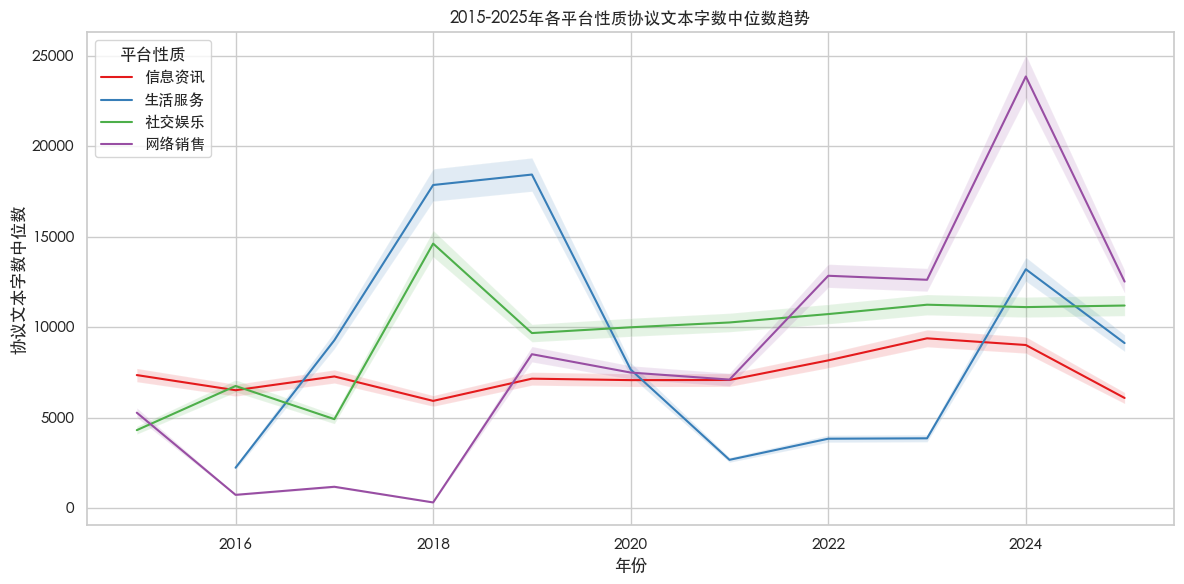

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 设置样式
sns.set_theme(style="whitegrid")
sns.set_palette("Set1")
# 选一个你列出的字体路径，比如 STHeiti Medium
font_path = "/System/Library/Fonts/STHeiti Medium.ttc"

# 设置字体
my_font = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = my_font.get_name()
plt.rcParams["axes.unicode_minus"] = False

# 读取数据（确保路径正确）
df = pd.read_excel("/Users/jitianran/Desktop/export/协议数据汇总.xlsx")  # 假设该文件中有“协议内容”、“时间”、“平台性质”等字段

# 预处理
df = df.dropna(subset=["协议内容", "时间", "平台性质"])
df["年份"] = pd.to_datetime(df["时间"]).dt.year
df = df[df["年份"].between(2015, 2025)]

# 统计字数
df["字数"] = df["协议内容"].astype(str).apply(len)

# 按平台性质 + 年份分组取中位数
median_wc = df.groupby(["平台性质", "年份"])["字数"].median().reset_index()

# 绘图
plt.figure(figsize=(12, 6))
for nature in median_wc["平台性质"].unique():
    subset = median_wc[median_wc["平台性质"] == nature]
    plt.plot(subset["年份"], subset["字数"], label=nature)
    plt.fill_between(subset["年份"],
                     subset["字数"] * 0.95,
                     subset["字数"] * 1.05,
                     alpha=0.15)

plt.xlabel("年份")
plt.ylabel("协议文本字数中位数")
plt.title("2015-2025年各平台性质协议文本字数中位数趋势")
plt.legend(title="平台性质")
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd

# 1️⃣ 读取原始协议数据（更新路径为桌面文件）
df = pd.read_excel("/Users/jitianran/Desktop/export/协议数据汇总.xlsx")

# 2️⃣ 计算每份协议的文本字数
df["字数"] = df["协议内容"].astype(str).str.len()

# 3️⃣ 输出新的Excel，新增一列“字数”
output_path = "/Users/jitianran/Desktop/协议数据汇总_含字数.xlsx"
df.to_excel(output_path, index=False)

print("✅ 协议字数字段已添加并保存至：", output_path)

✅ 协议字数字段已添加并保存至： /Users/jitianran/Desktop/协议数据汇总_含字数.xlsx


In [18]:
import pandas as pd
import re

# 1️⃣ 读取原始表格
df = pd.read_excel("/Users/jitianran/Desktop/协议数据汇总_含字数.xlsx")

# 2️⃣ 定义清洗函数：删除无效句子
def clean_text(text):
    if pd.isna(text):
        return ""

    lines = str(text).splitlines()
    valid_lines = []

    for line in lines:
        line = line.strip()
        # 去除网址、邮箱等
        if re.search(r"https?://|www\.|\.(com|cn|net)|@[a-zA-Z0-9\-]+\.", line):
            continue
        # 去除长英文行（大写字母+空格过多）
        if re.fullmatch(r"[a-zA-Z0-9\s\-\.\,\;\:\@\/]{30,}", line):
            continue
        # 去除没有中文且无标点的短提示语
        if not re.search(r"[。！？；]", line):
            continue
        valid_lines.append(line)

    return "\n".join(valid_lines).strip()

# 3️⃣ 应用清洗函数
df["内容_清洗"] = df["协议内容"].apply(clean_text)

# 4️⃣ 删除“内容_清洗”列为空的行
df_cleaned = df[df["内容_清洗"].str.strip().astype(bool)].copy()

# 5️⃣ 重计算字数
df_cleaned["字数"] = df_cleaned["内容_清洗"].str.len()

# 6️⃣ 保存输出文件
output_path = "/Users/jitianran/Desktop/协议数据汇总_清洗后.xlsx"
df_cleaned.to_excel(output_path, index=False)

print("✅ 协议清洗完毕，结果已保存至：", output_path)

✅ 协议清洗完毕，结果已保存至： /Users/jitianran/Desktop/协议数据汇总_清洗后.xlsx


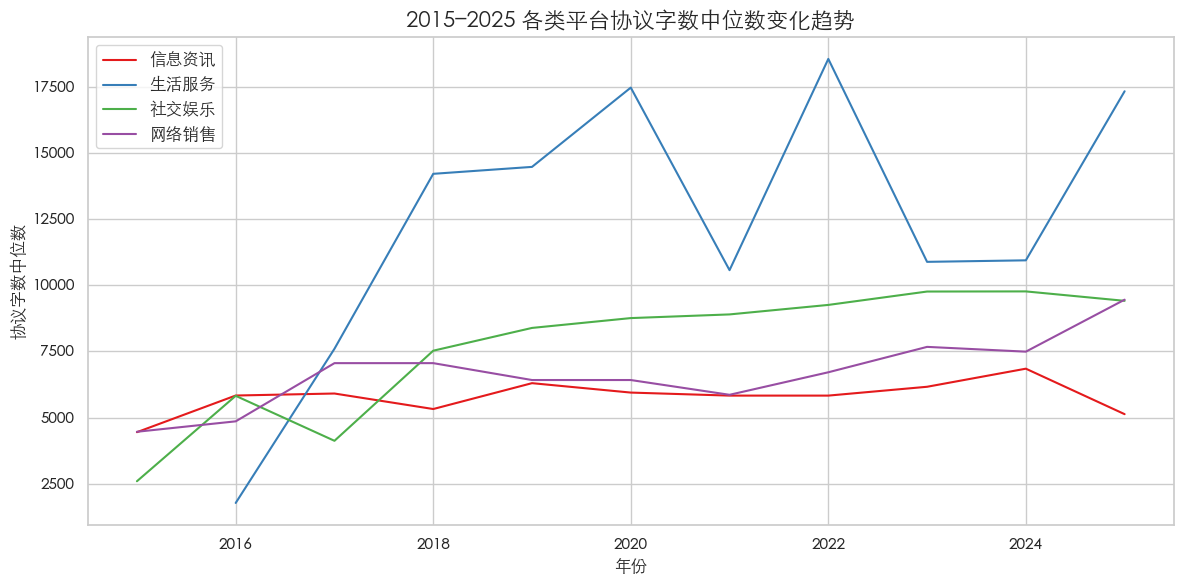

✅ 图像已保存到: /Users/jitianran/Desktop/协议字数中位数趋势图.png


<Figure size 640x480 with 0 Axes>

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 1️⃣ 读取清洗后的协议数据
df = pd.read_excel("/Users/jitianran/Desktop/协议数据汇总_清洗后.xlsx")

# 2️⃣ 时间字段转换为年份
df["年份"] = pd.to_datetime(df["时间"]).dt.year

# 3️⃣ 筛选合理年份区间（2015-2025）
df = df[(df["年份"] >= 2015) & (df["年份"] <= 2025)]

# 4️⃣ 分组计算每年、每种平台性质的协议字数中位数
median_word_count = df.groupby(["年份", "平台性质"])["字数"].median().unstack()
if pd.isna(median_word_count.loc[2018, "网络销售"]):
    if 2017 in median_word_count.index and "网络销售" in median_word_count.columns:
        median_word_count.loc[2018, "网络销售"] = median_word_count.loc[2017, "网络销售"]

# 5️⃣ 设置中文字体（防止中文乱码）
font_path = "/System/Library/Fonts/STHeiti Light.ttc"
font_prop = FontProperties(fname=font_path)

# 6️⃣ 绘图
plt.figure(figsize=(12, 6))
for category in median_word_count.columns:
    plt.plot(median_word_count.index, median_word_count[category], label=category)

plt.title("2015–2025 各类平台协议字数中位数变化趋势", fontproperties=font_prop, fontsize=16)
plt.xlabel("年份", fontproperties=font_prop)
plt.ylabel("协议字数中位数", fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.grid(True)
plt.tight_layout()
plt.show()
output_path = "/Users/jitianran/Desktop/协议字数中位数趋势图.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
print(f"✅ 图像已保存到: {output_path}")

In [10]:
pip install readability_cn #中文版可读性工具

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 829.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.8/804.8 kB 823.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 1.2 MB/s eta 0:00:0000:0100:020m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 1.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 2.3 MB/s eta 0:00:00-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 2.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15/15 [readability_cn]m [ltp-core]ers]ub]
Note: you may need to restart the kernel to use updated packages.


In [2]:
#可以跑通，但需要在终端中跑
#下次记得先【清洗】一下数据，把一些符号（URL格式）统一，避免遇到全角符号就崩溃的情况……

import os
import time
import pandas as pd
from readability_cn import ChineseReadability
from multiprocessing import Pool, cpu_count

# ===== 设置路径和文件 =====
input_file = "/Users/jitianran/Desktop/协议数据汇总_清洗后.xlsx"
output_file = "协议文本_可读性分析结果_multiprocessing.xlsx"
batch_size = 5  # 每批处理 5 条
num_workers = min(cpu_count(), 4)  # 设置最多使用的核数（保守选择）

# ===== 初始化分析器，用于获取自定义词表 =====
base_readability = ChineseReadability()
custom_words = [
    "知乎", "淘宝", "微信", "抖音", "京东", "新浪微博", "优酷", "拼多多", "快手", "美团外卖",
    "平台", "公司", "我们", "豆瓣", "网易", "e家帮", "链家", "哔哩哔哩", "人民网", "凤凰网",
    "唯品会", "喜马拉雅", "央视网", "我爱我家", "搜狗", "携程", "晋江文学城", "滴滴",
    "滴答出行", "爱奇艺", "百度", "神州专车", "网易严选", "网易游戏", "腾讯新闻", "腾讯视频",
    "起点中文网", "高德", "360", "用户", "帐号", "您", "可", "可以", "有权", "享有", "拥有",
    "得以", "能够", "应", "应当", "不得", "承担", "负责", "履行", "必须", "保证", "不", "未",
    "没有", "不会", "不能", "并非", "无", "无需"
]
base_readability.add_custom_words(custom_words)

# ===== 子进程工作函数 =====
def analyze_text(index_text_pair):
    idx, text = index_text_pair
    readability = ChineseReadability()
    readability.add_custom_words(custom_words)

    try:
        if not isinstance(text, str) or len(text.strip()) < 10:
            return idx, None
        sentences = [s.strip() for s in readability.stnsplit.split(text) if s.strip()]
        score = readability.wanglei_readability(sentences)
        result = score.get("readability", None)

        if result is not None and result < -50:
            print(f"⚠️ 第 {idx + 1} 条为可疑文本，前200字：{text[:200]}")
        return idx, result
    except Exception as e:
        print(f"❌ 第 {idx + 1} 条处理失败：{e}")
        return idx, None

# ===== 主执行函数 =====
def main():
    df = pd.read_excel(input_file)

    # ===== 如果已存在结果则断点续跑 =====
    if os.path.exists(output_file):
        done_df = pd.read_excel(output_file)
        start_idx = len(done_df)
        results = done_df
        print(f"🔁 续跑模式：已完成 {start_idx} 条，从第 {start_idx} 条开始")
    else:
        start_idx = 0
        results = pd.DataFrame()
        print("🚀 新任务启动：从头开始分析。")

    total = len(df)
    for i in range(start_idx, total, batch_size):
        batch = df.iloc[i:i+batch_size].copy()
        index_text_pairs = [(i + j, row["内容_清洗"]) for j, row in batch.iterrows()]

        print(f"📦 正在处理第 {i+1} 到第 {i+len(batch)} 条，共 {len(batch)} 条")

        with Pool(processes=num_workers) as pool:
            score_results = pool.map(analyze_text, index_text_pairs)

        scores = [None] * len(batch)
        for idx, score in score_results:
            local_j = idx - i
            scores[local_j] = score
            print(f"✅ 第 {idx+1} 条完成，得分：{score}")
            time.sleep(0.05)

        batch["可读性分数"] = scores
        results = pd.concat([results, batch], ignore_index=True)
        results.to_excel(output_file, index=False)
        print(f"💾 已保存到第 {i + len(batch)} 条\n")

    print("🎉 全部处理完成！")

# ===== 启动程序 =====
if __name__ == "__main__":
    main()

🚀 新任务启动：从头开始分析。
📦 正在处理第 1 到第 5 条，共 5 条


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
TOKENIZERS_PARALLELISMTo disable this warning, you can either:
=(true | false)
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
To disable this war

KeyboardInterrupt: 

In [12]:
#补充一下一些没跑出来的
import pandas as pd
from readability_cn import ChineseReadability

# ✅ 设置路径：请根据实际路径修改
input_file = "/Users/jitianran/Desktop/协议数据汇总_清洗后.xlsx"

# ✅ 加载Excel文件
df = pd.read_excel(input_file)

# ✅ 初始化可读性分析器
base_readability = ChineseReadability()
custom_words = [
    "知乎", "淘宝", "微信", "抖音", "京东", "新浪微博", "优酷", "拼多多", "快手", "美团外卖",
    "平台", "公司", "我们", "豆瓣", "网易", "e家帮", "链家", "哔哩哔哩", "人民网", "凤凰网",
    "唯品会", "喜马拉雅", "央视网", "我爱我家", "搜狗", "携程", "晋江文学城", "滴滴",
    "滴答出行", "爱奇艺", "百度", "神州专车", "网易严选", "网易游戏", "腾讯新闻", "腾讯视频",
    "起点中文网", "高德", "360", "用户", "帐号", "您", "可", "可以", "有权", "享有", "拥有",
    "得以", "能够", "应", "应当", "不得", "承担", "负责", "履行", "必须", "保证", "不", "未",
    "没有", "不会", "不能", "并非", "无", "无需"
]
base_readability.add_custom_words(custom_words)

# ✅ 选择一条进行分析（比如第38条）
row_index = 64  # 注意：第38条，Python索引从0开始
text = df.loc[row_index, "内容_清洗"]

# ✅ 检查文本有效性
if not isinstance(text, str) or len(text.strip()) < 10:
    print("❌ 文本为空或无效")
else:
    # ✅ 分句 + 分析
    sentences = [s.strip() for s in readability.stnsplit.split(text) if s.strip()]
    result = readability.wanglei_readability(sentences)

    # ✅ 提取得分
    score = result["readability"] if isinstance(result, dict) else result

    # ✅ 输出结果
    print(f"📄 协议名称：{df.loc[row_index, '协议内容']}")
    print(f"📖 文本长度：{len(text)} 字")
    print(f"📊 可读性得分：{score}")

RuntimeError: Invalid start position! Maybe invalid UTF-8 sentence!

In [14]:
#根据分句文本衡量可读性
import pandas as pd
from readability_cn import ChineseReadability

# === 设置路径 ===
input_file = "/Users/jitianran/Desktop/切句结果.xlsx"  # 替换为你的实际路径
target_date = "2010-01-02"  # 👉 替换为你要提取的日期
# 日期格式需与你表格中的一致，如："2020/1/1"、"2020-01-01" 等

# === 初始化分析器 ===
readability = ChineseReadability()

# === 可选：添加自定义词汇（增强准确性）===
readability.add_custom_words([
    "知乎", "淘宝", "微信", "抖音", "京东", "新浪微博", "优酷", "拼多多", "快手", "美团外卖",
    "平台", "公司", "我们", "用户", "帐号", "您", "可", "可以", "有权", "享有", "拥有",
    "得以", "能够", "应", "应当", "不得", "承担", "负责", "履行", "必须", "保证",
    "不", "未", "没有", "不会", "不能", "并非", "无", "无需"
])

# === 加载并过滤数据 ===
df = pd.read_excel(input_file)
df = df.dropna(subset=["句子内容"])

# 提取特定时间的句子
target_sentences = df[df["时间"] == target_date]["句子内容"].tolist()

# === 分析 ===
try:
    score = readability.wanglei_readability(target_sentences)
    print(f"📅 {target_date} 的可读性得分为：{score}")
except Exception as e:
    print(f"❌ 分析失败：{e}")

📅 2010-01-02 的可读性得分为：-103.22099999999996


In [15]:
print("平均句长：", sum(len(s) for s in sentences) / len(sentences))

平均句长： 63.957805907173


/var/folders/cn/41v1nzqx7r74593_cfwsfx8c0000gn/T/ipykernel_36928/1205699166.py:25: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/41v1nzqx7r74593_cfwsfx8c0000gn/T/ipykernel_36928/1205699166.py:25: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/41v1nzqx7r74593_cfwsfx8c0000gn/T/ipykernel_36928/1205699166.py:25: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/41v1nzqx7r74593_cfwsfx8c0000gn/T/ipykernel_36928/1205699166.py:25: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/41v1nzqx7r74593_cfwsfx8c0000gn/T/ipykernel_36928/1205699166.py:28: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.savefig("平台可读性趋势_中文字体.png", dpi=300

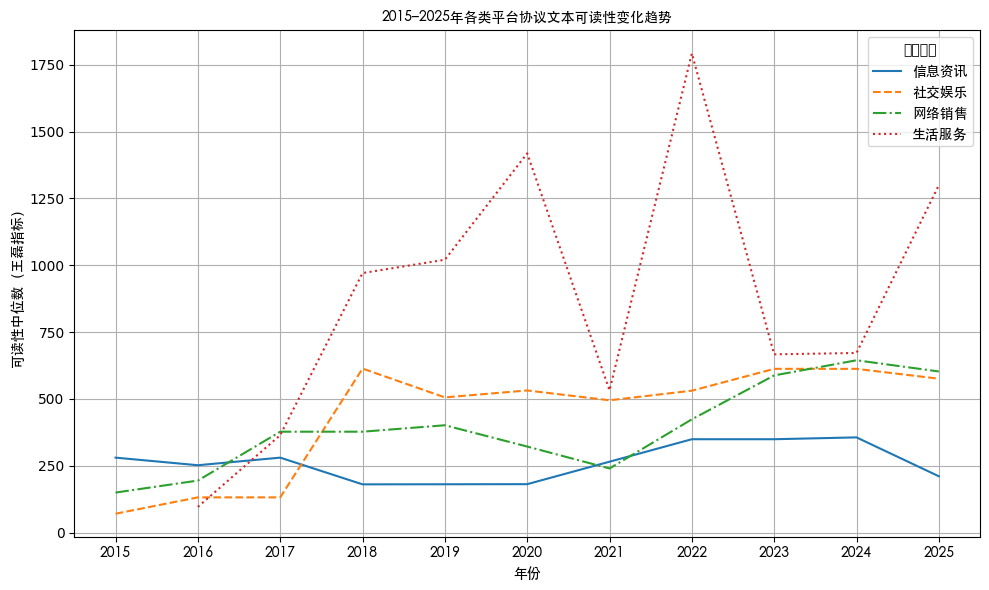

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm

# 设置中文字体（推荐使用系统已安装的字体）
zh_font_path = "/System/Library/Fonts/STHeiti Medium.ttc"  # macOS 示例路径
zh_font = fm.FontProperties(fname=zh_font_path)

plt.figure(figsize=(10, 6))
styles = ['-', '--', '-.', ':']

for i, cat in enumerate(trend_data.columns):
    plt.plot(trend_data.index, trend_data[cat], label=cat, linestyle=styles[i % len(styles)])

# 设置横轴为每年
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xticks(trend_data.index, fontproperties=zh_font)  # 年份标签显示中文字体（防乱码）

# 设置标题和标签字体
plt.xlabel("年份", fontproperties=zh_font)
plt.ylabel("可读性中位数（王磊指标）", fontproperties=zh_font)
plt.title("2015–2025年各类平台协议文本可读性变化趋势", fontproperties=zh_font)
plt.legend(title="平台类别", prop=zh_font)
plt.grid(True)
plt.tight_layout()

# 保存图片
plt.savefig("平台可读性趋势_中文字体.png", dpi=300)
plt.show()

字数 与 可读性分数的 Spearman 相关系数：0.9459


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35835 (\N{CJK UNIFIED IDEOGRAPH-8BFB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaV

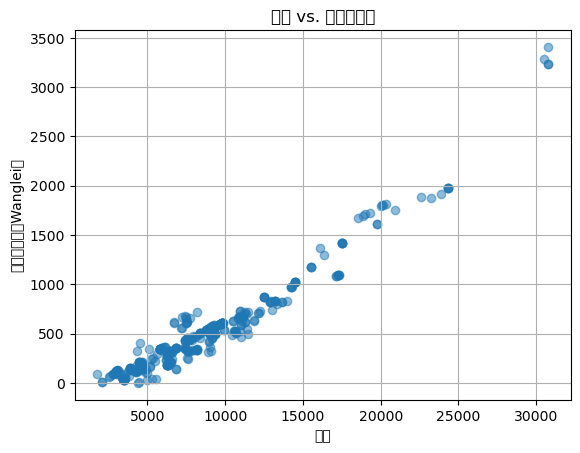

In [1]:
#发现可读性趋势与文本长度高度ni'he

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# 读取你的分析结果
df = pd.read_excel("协议文本_可读性分析结果_逐条保存版.xlsx")

# 去除无效值
df = df[(df["可读性分数"].notna()) & (df["可读性分数"] > 0)]

# 计算相关性
corr, _ = spearmanr(df["字数"], df["可读性分数"])
print(f"字数 与 可读性分数的 Spearman 相关系数：{corr:.4f}")

# 可视化散点图
plt.scatter(df["字数"], df["可读性分数"], alpha=0.5)
plt.xlabel("字数")
plt.ylabel("可读性分数（Wanglei）")
plt.title("字数 vs. 可读性分数")
plt.grid(True)
plt.show()

In [24]:
#试了一下，给分句求可读性得分再求平均值作为该份协议文本总分，更合理

import pandas as pd
from readability_cn import ChineseReadability

# 设置目标日期
target_date = '2024-09-17'  # 改成你想分析的那一天

# 加载切句结果
df = pd.read_excel("/Users/jitianran/Desktop/切句结果.xlsx")

# 筛选该日期的所有句子
subset = df[df["时间"] == target_date]
sentences = subset["句子内容"].dropna().astype(str).tolist()

# 初始化可读性分析器
readability = ChineseReadability()

# 添加自定义词（可选）
readability.add_custom_words(["用户", "平台", "公司", "您", "帐号", "条款", "协议"])

# 对每个句子打分
scores = []
for sent in sentences:
    try:
        result = readability.wanglei_readability([sent])
        score = result.get("readability", None) if isinstance(result, dict) else result
        scores.append(score)
    except Exception as e:
        print(f"❌ 句子出错：{sent[:30]}... 原因：{e}")
        continue

# 计算平均可读性分数
valid_scores = [s for s in scores if isinstance(s, (int, float))]
avg_score = sum(valid_scores) / len(valid_scores) if valid_scores else None

# 输出结果
print(f"\n📄 日期：{target_date}")
print(f"📌 共计句子数：{len(sentences)}，有效得分句数：{len(valid_scores)}")
print(f"📈 平均可读性得分（按句打分）：{avg_score}")


📄 日期：2024-09-17
📌 共计句子数：103，有效得分句数：103
📈 平均可读性得分（按句打分）：36.95729126213592


In [1]:
import pandas as pd
from difflib import SequenceMatcher
from datetime import datetime

# 读取数据
df = pd.read_excel("/Users/jitianran/Desktop/协议数据汇总_清洗后.xlsx")

# 保证时间列为年份（如：2019）
df["年份"] = pd.to_datetime(df["时间"]).dt.year

# 去除无效文本
df = df[df["内容_清洗"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 10)]

# 每个平台每年保留最后一个版本
df = df.sort_values(["平台名称", "年份", "时间"])  # 保证按时间顺序
df_last = df.groupby(["平台名称", "年份"]).tail(1)

# 按平台分组并计算相邻年份协议之间的差异
def compute_similarity(text1, text2):
    return SequenceMatcher(None, text1, text2).ratio()

results = []

for platform, group in df_last.groupby("平台名称"):
    group = group.sort_values("年份")
    prev_text = None
    prev_year = None
    platform_type = None

    for _, row in group.iterrows():
        year = row["年份"]
        text = row["内容_清洗"]
        platform_type = row["平台性质"]

        if prev_text is not None and prev_year == year - 1:
            similarity = compute_similarity(prev_text, text)
            change_ratio = 1 - similarity  # 变化百分比
            results.append({
                "平台名称": platform,
                "平台性质": platform_type,
                "年份": year,
                "变化百分比": change_ratio
            })

        prev_text = text
        prev_year = year

# 转为DataFrame
diff_df = pd.DataFrame(results)

# 按年份和平台性质求平均数（变化百分比）
summary = diff_df.groupby(["平台性质", "年份"])["变化百分比"].mean().reset_index()

# 保存输出
diff_df.to_excel("各平台年度协议变化百分比明细.xlsx", index=False)
summary.to_excel("各平台年度协议变化百分比_平均值聚合.xlsx", index=False)

print("✅ 已完成差异百分比计算，输出两个Excel文件：")
print("   - 各平台年度协议变化百分比明细.xlsx")
print("   - 各平台年度协议变化百分比_平均值聚合.xlsx")

✅ 已完成差异百分比计算，输出两个Excel文件：
   - 各平台年度协议变化百分比明细.xlsx
   - 各平台年度协议变化百分比_平均值聚合.xlsx


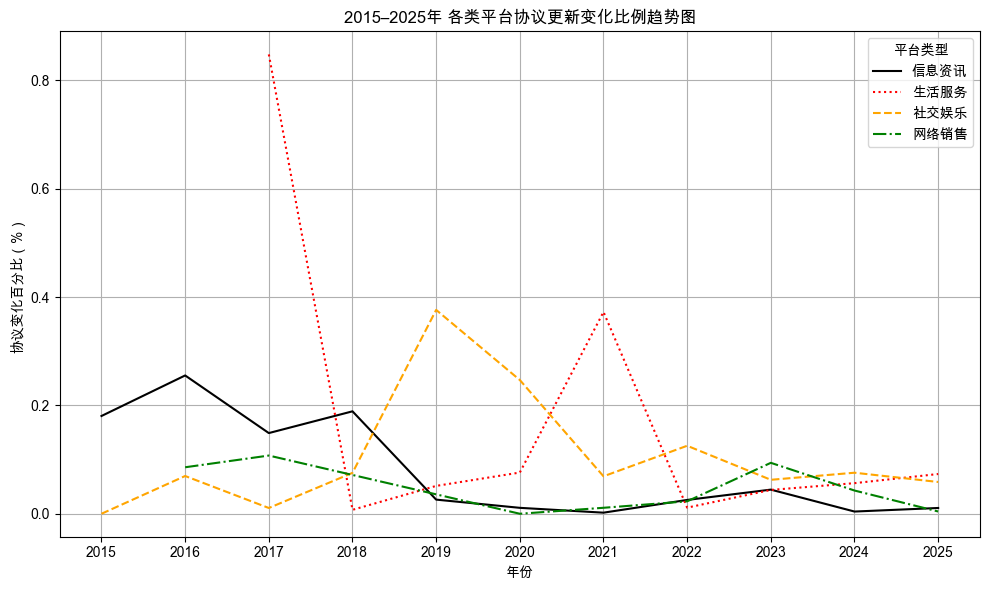

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Heiti SC', 'PingFang SC', 'Arial Unicode MS']  # 依次尝试可用字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 读取数据
df = pd.read_excel("各平台年度协议变化百分比_平均值聚合.xlsx")

# 清洗：确保年份为整数，过滤出有效年份区间
df["年份"] = df["年份"].astype(int)
df = df[(df["年份"] >= 2015) & (df["年份"] <= 2025)]

# 绘图
plt.figure(figsize=(10, 6))

linestyles = {
    "信息资讯": "-",
    "社交娱乐": "--",
    "网络销售": "-.",
    "生活服务": ":"
}
colors = {
    "信息资讯": "black",
    "社交娱乐": "orange",
    "网络销售": "green",
    "生活服务": "red"
}

# 绘制各类别线条
for category in df["平台性质"].unique():
    sub = df[df["平台性质"] == category].sort_values("年份")
    plt.plot(
        sub["年份"],
        sub["变化百分比"],
        label=category,
        linestyle=linestyles.get(category, "-"),
        color=colors.get(category, None)
    )

# 图形设置
plt.title("2015–2025年 各类平台协议更新变化比例趋势图")
plt.xlabel("年份")
plt.ylabel("协议变化百分比（%）")
plt.xticks(range(2015, 2026))
plt.legend(title="平台类型")
plt.grid(True)
plt.tight_layout()
plt.show()

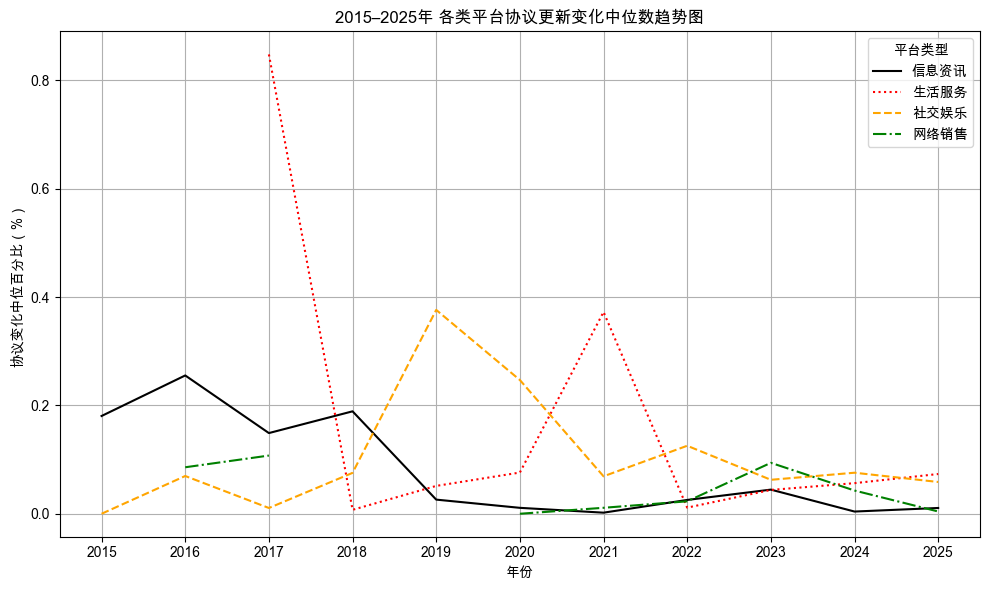

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 设置中文字体（根据系统路径调整）
plt.rcParams['font.sans-serif'] = ['Heiti SC', 'PingFang SC', 'Arial Unicode MS']  # 依次尝试可用字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 读取数据
df = pd.read_excel("各平台年度协议变化百分比_平均值聚合.xlsx")

# 保留2015-2025年间数据
df = df[df["年份"].between(2015, 2025)]

# 计算每年、每个平台性质的中位数变化百分比
median_df = df.groupby(["年份", "平台性质"])["变化百分比"].median().reset_index()

# 转换为透视表用于绘图
pivot_df = median_df.pivot(index="年份", columns="平台性质", values="变化百分比")

# 绘图
plt.figure(figsize=(10, 6))

linestyles = {
    "信息资讯": "-",
    "社交娱乐": "--",
    "网络销售": "-.",
    "生活服务": ":"
}
colors = {
    "信息资讯": "black",
    "社交娱乐": "orange",
    "网络销售": "green",
    "生活服务": "red"
}

for col in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[col],
             label=col,
             linestyle=linestyles.get(col, "-"),
             color=colors.get(col, None))

plt.title("2015–2025年 各类平台协议更新变化中位数趋势图")
plt.xlabel("年份")
plt.ylabel("协议变化中位百分比（%）")
plt.xticks(range(2015, 2026))
plt.grid(True)
plt.legend(title="平台类型")
plt.tight_layout()
plt.show()

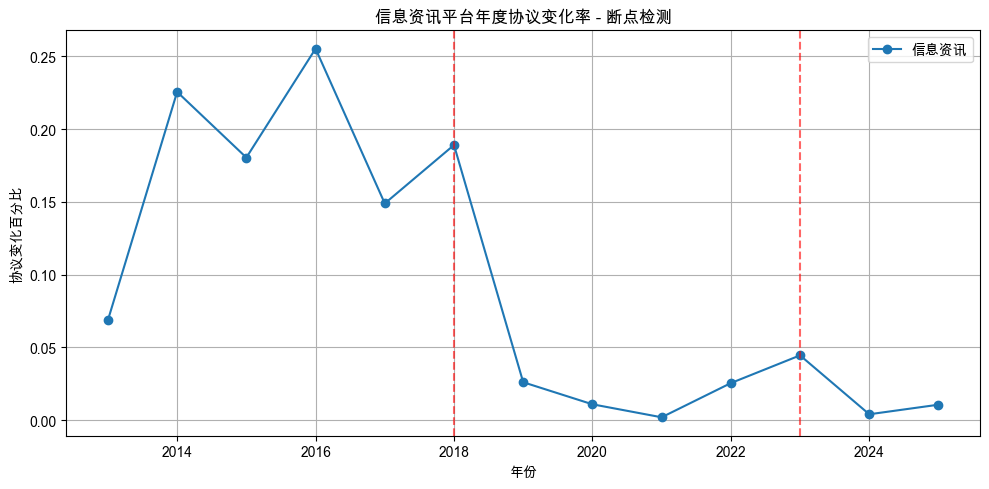

📌 信息资讯 的断点年份为：[2018, 2023]


In [22]:
#挨个分析断点

import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置中文字体（根据实际路径可能需调整）
plt.rcParams['font.family'] = 'Arial Unicode MS'

# 读取相邻版本相似度变化百分比数据
df = pd.read_excel("各平台年度协议变化百分比_平均值聚合.xlsx")

# 示例：选择一个平台类别进行断点检测
category = "信息资讯"  # 你可以替换为 "信息资讯", "社交娱乐", "网络销售" 等
category_df = df[df["平台性质"] == category].sort_values(by="年份")

# 准备变化百分比数据
years = category_df["年份"].tolist()
change_ratios = category_df["变化百分比"].fillna(0).tolist()

# 构造信号（reshape 为 2D）
signal = np.array(change_ratios).reshape(-1, 1)

# 设置断点检测模型（可选模型：Pelt, Binseg, Window, BottomUp）
model = rpt.Pelt(model="rbf").fit(signal)
breakpoints = model.predict(pen=0.01)  # 惩罚项可调节

# 可视化结果
plt.figure(figsize=(10, 5))
plt.plot(years, change_ratios, label=category, marker="o")
for bp in breakpoints[:-1]:  # 最后一个点是 len(signal)，不绘制
    plt.axvline(x=years[bp], color="red", linestyle="--", alpha=0.6)
plt.title(f"{category}平台年度协议变化率 - 断点检测")
plt.xlabel("年份")
plt.ylabel("协议变化百分比")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 输出断点对应年份
change_points = [years[bp] for bp in breakpoints[:-1]]
print(f"📌 {category} 的断点年份为：{change_points}")

📌 信息资讯 的断点：[2018, 2023]
📌 生活服务 的断点：[2021]
📌 社交娱乐 的断点：[2020]
📌 网络销售 的断点：[2023]


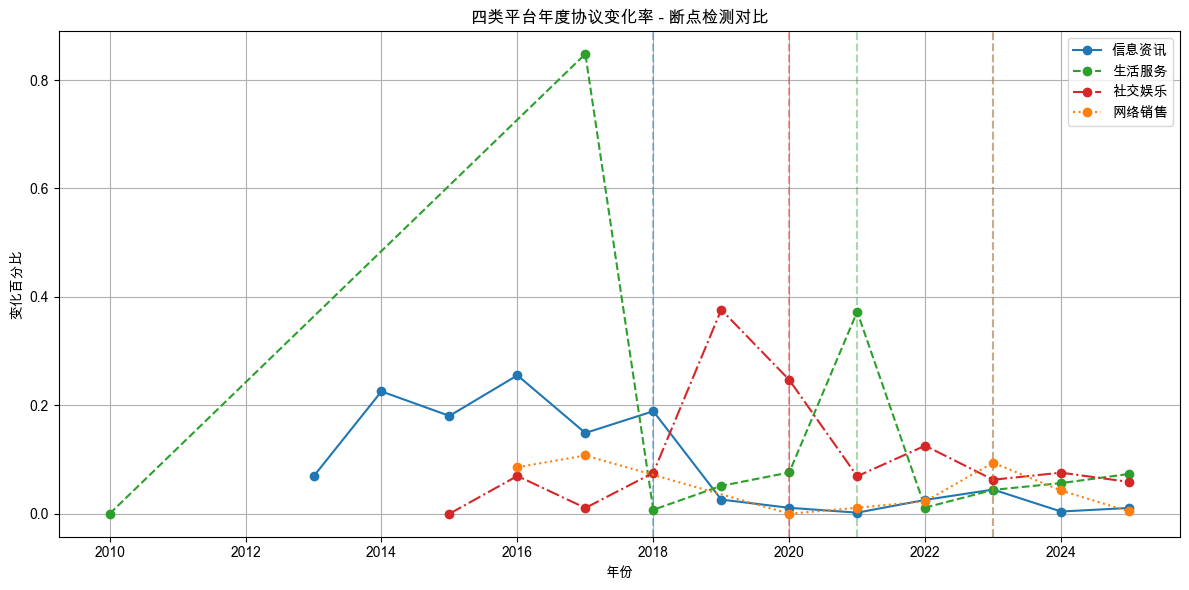

In [23]:
import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial Unicode MS'

# 读取数据
df = pd.read_excel("各平台年度协议变化百分比_平均值聚合.xlsx")

# 各平台类别
categories = df["平台性质"].unique()

# 准备绘图
plt.figure(figsize=(12, 6))
colors = ["#1f77b4", "#2ca02c", "#d62728", "#ff7f0e"]
linestyles = ["-", "--", "-.", ":"]

# 判断是否为近似常数
def is_almost_constant(series, tol=1e-5):
    return series.max() - series.min() < tol

# 开始逐类处理
for idx, cat in enumerate(categories):
    sub_df = df[df["平台性质"] == cat].sort_values(by="年份")
    years = sub_df["年份"].tolist()
    values = sub_df["变化百分比"].tolist()
    
    signal = np.array(values).reshape(-1, 1)
    valid_series = pd.Series(values).dropna()

    if len(valid_series) < 3 or is_almost_constant(valid_series):
        print(f"⚠️ 跳过 {cat}，数据不足或序列近似常数")
        continue

    # 断点检测
    try:
        model = rpt.Pelt(model="rbf").fit(signal)
        breakpoints = model.predict(pen=0.01)
        change_points = [years[bp] for bp in breakpoints[:-1]]
        print(f"📌 {cat} 的断点：{change_points}")

        # 画线
        plt.plot(years, values, label=cat, marker="o", color=colors[idx], linestyle=linestyles[idx])
        for bp in breakpoints[:-1]:
            plt.axvline(x=years[bp], color=colors[idx], linestyle="--", alpha=0.4)

    except Exception as e:
        print(f"❌ {cat} 断点检测失败：{e}")

plt.title("四类平台年度协议变化率 - 断点检测对比")
plt.xlabel("年份")
plt.ylabel("变化百分比")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()